# Topic Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Spacy
import spacy

# Scipy
import scipy.sparse

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# Gensim
from gensim import matutils
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# Pyldavis
import pyLDAvis
import pyLDAvis.gensim

#### Color Palette

In [32]:
blush = '#F7D1CD'
pink = '#E8C2CA'
light_purple = '#D1B3C4'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

## Read-In Data

In [2]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')
pospar = pd.read_csv('../data/postpartum_preprocessed.csv')
print(f'Pospar: {pospar.shape}')

Health: (30616, 8)
ObsGyn: (92943, 8)
Pospar: (49094, 8)


## Define Stop Words

In [3]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [4]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)

## Create Document Term Matrix From Corpus

#### Function

In [5]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create Document Term Matrix

In [6]:
# Vectorizer, dtm are outputed from build_tvec

health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')
pospar_vectorizer, pospar_dtm = build_tvec(pospar, 'lemma_text')

#### Transform Document Term Matrix into a Term Document Matrix that can be recognized by Gensim

**Note**: Code for these steps was modified from [A Dash of Data](https://github.com/adashofdata/nlp-in-python-tutorial) by Alice Zhao

In [7]:
def create_tdm(dtm):
    tdm = dtm.transpose()
    return tdm

In [8]:
def tdm_to_gensim_corpus(tdm):
    sparse = scipy.sparse.csr_matrix(tdm) # Create a compressed sparse row matrix
    corpus = matutils.Sparse2Corpus(tdm) # Create a corpus from sparse matrix
    return corpus

In [9]:
def prepare_dtm_for_gensim(dtm):
    tdm = create_tdm(dtm)
    corpus = tdm_to_gensim_corpus(tdm)
    return corpus

In [10]:
health_corpus = prepare_dtm_for_gensim(health_dtm)
obsgyn_corpus = prepare_dtm_for_gensim(obsgyn_dtm)
pospar_corpus = prepare_dtm_for_gensim(pospar_dtm)

## Define Vocabulary Dictionary from Vectorizer

In [11]:
def create_vocab_dictionary(vectorizer):
    vocab_dictionary = dict((v,k) for k,v in vectorizer.vocabulary_.items())
    return vocab_dictionary

In [12]:
health_vocabulary = create_vocab_dictionary(health_vectorizer)
obsgyn_vocabulary = create_vocab_dictionary(obsgyn_vectorizer)
pospar_vocabulary = create_vocab_dictionary(pospar_vectorizer)

## Modeling

### Build LSA Models

In [13]:
def build_gensim_lsa(dtm, dictionary, n_topics):
    lsa = LsiModel(dtm, num_topics = n_topics, id2word = dictionary)
    return lsa   

In [14]:
def grid_search_lsa(df, column, stopwords, start, stop, step_size):
    clean_text, dictionary, dtm = gensim_preprocessing(df, column, stopwords)
    
    models_dict = {}
    coherence_list = []
    
    for i in range(start, stop, step_size):
        print(f'Building LSA model for {i} topics')
        lsa_model = build_gensim_lsa(dtm, dictionary, i)
        models_dict[i] = lsa_model
        print('Calculating coherence score')
        coherence = build_gensim_coherence_model(lsa_model, corpus, dictionary)
        coherence_list.append(coherence)
    
    print('Finished!')
    
    return models_dict, coherence_list

In [15]:
def build_gensim_coherence_model(model, corpus, dictionary):
    coherence = CoherenceModel(model=model, corpus = corpus, dictionary = dictionary, coherence = 'u_mass')
    return round(coherence.get_coherence(), 3)

In [16]:
def get_topic_terms(model, n_topics, n_words):
    return model.print_topics(num_topics = n_topics, num_words = n_words)

### Build LDA Models

#### Functions

In [17]:
def build_gensim_lda(corpus, n_topics, vocabulary, n_passes):
    lda = LdaModel(corpus = corpus, num_topics = n_topics, id2word = vocabulary, passes = n_passes, decay = 0.7, offset = 10, random_state = 2020 )
    return lda

In [53]:
def grid_search_lda(corpus, vocabulary, n_passes, start, stop, step_size):
    
    models_dict = {}
    coherence_list = []
    
    for i in range(start, stop, step_size):
        print(f'Building LDA model for {i} topics')
        lda_model = build_gensim_lda(corpus, i, vocabulary, n_passes)
        models_dict[i] = lda_model # Save model as dictionary with # topics as key
        print('Calculating coherence score')
        coherence = build_gensim_coherence_model(lda_model, corpus, vocabulary)
        coherence_list.append(coherence)
#         perplexity = lda_model.log_perplexity(corpus)
#         perplexity_list.append(perplexity)
    
    print('Finished!')
    
    return models_dict, coherence_list

In [26]:
# Function Written By Selva Prabhakaran
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df.columns = ['Dominant_Topic', 'Percent_Dominant_Topic', 'Keywords', 'Original_Text']
    
    return sent_topics_df

In [ ]:
def plot_coherence_by_topic(start, stop, step_size, coherence_list, size = (10,6), title = None, x_label = None, y_label = None):
    plt.figure(figsize = size)
    sns.lineplot(x = range(start, stop, step_size), y = coherence_list, linewidth = 2, color = dark_purple)
    plt.xlabel(x_label, fontdict = {'fontsize':12}, labelpad = 8)
    plt.ylabel(y_label, fontdict = {'fontsize':12}, labelpad = 8)
    plt.title(title, fontdict = {'fontsize':15}, pad = 8)
    plt.xticks(size = 11)
    plt.yticks(size = 11)
    plt.tight_layout();

#### General Women's Health Data

In [19]:
health_lda_models, health_lda_coherence = grid_search_lda(corpus = health_corpus, 
                                                          vocabulary = health_vocabulary, 
                                                          n_passes = 25, 
                                                          start = 5, 
                                                          stop = 20, 
                                                          step_size = 1)

Building LDA model for 5 topics
Calculating coherence score
Building LDA model for 6 topics
Calculating coherence score
Building LDA model for 7 topics
Calculating coherence score
Building LDA model for 8 topics
Calculating coherence score
Building LDA model for 9 topics
Calculating coherence score
Building LDA model for 10 topics
Calculating coherence score
Building LDA model for 11 topics
Calculating coherence score
Building LDA model for 12 topics
Calculating coherence score
Building LDA model for 13 topics
Calculating coherence score
Building LDA model for 14 topics
Calculating coherence score
Building LDA model for 15 topics
Calculating coherence score
Building LDA model for 16 topics
Calculating coherence score
Building LDA model for 17 topics
Calculating coherence score
Building LDA model for 18 topics
Calculating coherence score
Building LDA model for 19 topics
Calculating coherence score
Finished!


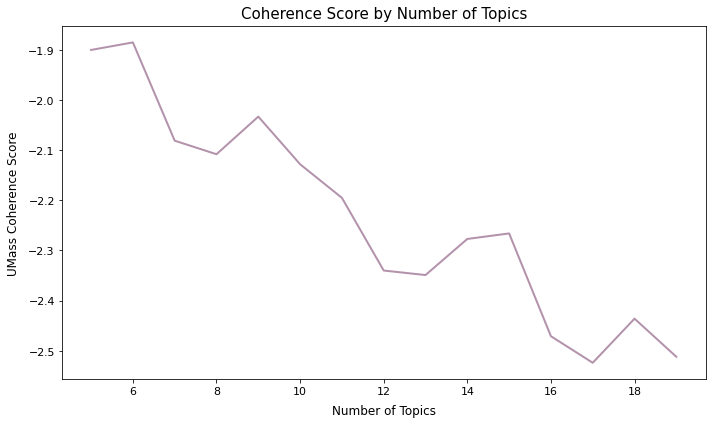

In [47]:
plot_coherence_by_topic(5, 20, 1, 
                        health_lda_coherence_, 
                        size = (10,6), 
                        title = 'Coherence Score by Number of Women\'s Health Topics', 
                        x_label = 'Number of Topics', 
                        y_label = 'UMass Coherence Score')

In [28]:
health_lda_model = build_gensim_lda(health_corpus, 
                               n_topics = 15, 
                               vocabulary = health_vocabulary, 
                               n_passes = 100)

In [49]:
get_topic_terms(health_lda_model, 15, 20)

[(0,
  '0.270*"iud" + 0.073*"mirena" + 0.059*"copper" + 0.045*"copper iud" + 0.040*"insertion" + 0.036*"kyleena" + 0.034*"string" + 0.027*"remove" + 0.027*"mirena iud" + 0.024*"insert" + 0.023*"experience" + 0.021*"removal" + 0.014*"hormonal" + 0.014*"cramp" + 0.011*"place" + 0.009*"expect" + 0.009*"cramping" + 0.009*"replace" + 0.008*"concern" + 0.008*"uterus"'),
 (1,
  '0.060*"smell" + 0.035*"wash" + 0.031*"deodorant" + 0.030*"shower" + 0.026*"use" + 0.026*"skin" + 0.025*"sweat" + 0.022*"product" + 0.020*"makeup" + 0.020*"tip" + 0.020*"clean" + 0.019*"face" + 0.018*"soap" + 0.015*"water" + 0.014*"eye" + 0.014*"routine" + 0.013*"dry" + 0.013*"acne" + 0.013*"oil" + 0.012*"bath"'),
 (2,
  '0.025*"wear" + 0.016*"look" + 0.016*"dress" + 0.011*"bra" + 0.009*"buy" + 0.009*"clothe" + 0.007*"good" + 0.007*"size" + 0.007*"jean" + 0.007*"makeup" + 0.007*"find" + 0.007*"style" + 0.006*"fit" + 0.006*"help" + 0.006*"girl" + 0.006*"short" + 0.006*"cute" + 0.006*"need" + 0.006*"shoe" + 0.005*"work"'

In [30]:
build_gensim_coherence_model(health_lda_model, corpus = health_corpus, dictionary = health_vocabulary)

-2.259

In [ ]:
# pyLDAvis.gensim.prepare(df_lda_17, health_corpus, health_vocabulary)

#### Fertility and Pregnancy

In [ ]:
obsgyn_lda_models, obsgyn_lda_coherence = grid_search_lda(corpus = obsgyn_corpus, 
                                                          vocabulary = obsgyn_vocabulary, 
                                                          n_passes = 25, 
                                                          start = 2, 
                                                          stop = 30, 
                                                          step_size = 2)

Building LDA model for 2 topics
Calculating coherence score
Building LDA model for 4 topics
